In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [15]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [16]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [17]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [18]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [19]:
input_size = 784
output_size = 10

In [20]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [21]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [22]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [253]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass

In [400]:
### shift normalized dists towards 0 for sparse activation with exponential
class DistanceTransform_Exp(DistanceTransform):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, eps=1e-5):
        super().__init__(input_dim, num_centers, p=2)
        
        self.scaler = nn.Parameter(torch.ones(1, num_centers)*3/3)
#         self.bias = nn.Parameter(torch.ones(1, num_centers)*-0.1) if bias else None
        self.bias = nn.Parameter(torch.ones(1, num_centers)*0) if bias else None
        self.eps = eps
        
    def forward(self, x):
        dists = super().forward(x)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
        dists = dists-dists.mean(dim=1, keepdim=True)
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+self.eps)
#         a = ((-dists-2)*self.scaler).data.cpu().numpy()
#         print(a.mean(), a.std(), a.min(), a.max())
        dists = torch.exp((-dists-2)*self.scaler)
#         dists = torch.softmax((-dists-3)*self.scaler, dim=1)
        if self.bias is not None: dists = dists+self.bias
        return dists

In [687]:
### shift normalized dists towards 0 for sparse activation with exponential
class DistanceTransform_MinExp(DistanceTransform):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, eps=1e-5):
        super().__init__(input_dim, num_centers, p=2)
        
        self.scaler = nn.Parameter(torch.ones(1, num_centers)*6/3)
        self.scaler.requires_grad = False
#         self.bias = nn.Parameter(torch.ones(1, num_centers)*-0.1) if bias else None
        self.bias = nn.Parameter(torch.ones(1, num_centers)*0) if bias else None
        self.eps = eps
        
    def forward(self, x):
        dists = super().forward(x)
        
        ### normalize similar to UMAP
        dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+self.eps)

        dists = torch.exp(-dists*self.scaler)
#         dists = torch.softmax(-dists*self.scaler, dim=1)
        if self.bias is not None: dists = dists+self.bias
        return dists

In [688]:
# dt = DistanceTransform(784, 20)
dt = DistanceTransform_Exp(784, 20)
# dt = DistanceTransform_MinExp(784, 20)

In [689]:
dists = dt(torch.randn(2, 784))

In [690]:
dists.shape

torch.Size([2, 20])

In [691]:
dists.data

tensor([[0.1859, 0.0220, 0.1711, 0.2191, 0.0910, 1.0389, 0.1123, 0.0904, 0.0287,
         0.6401, 0.0426, 0.0698, 0.1426, 0.0760, 0.3553, 0.1315, 0.1283, 0.5974,
         0.2096, 0.0650],
        [0.2351, 0.2969, 0.0297, 0.2467, 0.1092, 0.2005, 0.0567, 0.3328, 0.0413,
         0.0509, 0.3716, 0.0511, 0.0225, 0.1329, 0.7416, 0.2086, 0.2699, 0.5212,
         0.1337, 0.0580]])

In [692]:
dists.data.max(dim=1)[0], dists.data.min(dim=1)[0]

(tensor([1.0389, 0.7416]), tensor([0.0220, 0.0225]))

In [693]:
dt.set_centroid_to_data_randomly(train_loader)

In [694]:
# dt.set_centroid_to_data(train_loader)

In [695]:
class DTinverseDT(nn.Module):
    
    def __init__(self, dt):
        super().__init__()
        self.dt = dt
        
    def forward(self, x):
        dists = self.dt(x)
        dists = dists-dists.min(dim=1, keepdim=True)[0]
        
        scaler = torch.softmax(dists, dim=1)
        output = torch.matmul(scaler, self.dt.centers)
        return output

In [696]:
dtidt = DTinverseDT(DistanceTransform(784, 20))

In [697]:
dtidt.dt.set_centroid_to_data_randomly(train_loader)

In [698]:
dtidt(torch.randn(2, 784)).shape

torch.Size([2, 784])

In [699]:
xx, yy = train_dataset[[0,1]]
yy = dtidt(xx)

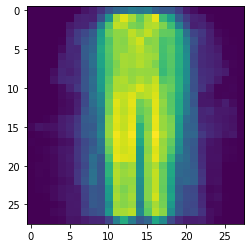

In [700]:
plt.imshow(yy.data[0].reshape(28, 28))

## Distance Attention Layer

In [701]:
class DistanceAttention(nn.Module):
    
    def __init__(self, input_dim, output_dim, p=2):
        super().__init__()
        self.dt = DistanceTransform_Exp(input_dim, output_dim, p=2)
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        scaler = self.dt(x)
        output = self.linear(x)
        return output*scaler

In [702]:
da = DistanceAttention(784, 20)
da.to(device)

DistanceAttention(
  (dt): DistanceTransform_Exp()
  (linear): Linear(in_features=784, out_features=20, bias=True)
)

In [703]:
out = da(torch.randn(2, 784).to(device))
out

tensor([[-3.9796e-01, -1.3134e-02,  4.0913e-02, -1.8343e-02, -3.7873e-03,
          1.2622e-01,  3.8082e-02,  9.5710e-01, -1.5502e-01,  1.7526e-02,
         -6.8423e-02,  4.3531e-02,  1.2362e-01,  2.6628e-02,  6.3377e-02,
         -9.3400e-03, -7.6672e-02, -3.3488e-02, -2.2948e-02,  1.8914e-01],
        [-4.1774e-02, -9.5750e-02,  1.0433e-02, -7.3843e-02, -9.4855e-03,
         -1.0590e-01, -2.8735e-02,  1.3591e-02,  5.9072e-01, -3.5581e-03,
         -9.4183e-04,  8.9716e-03,  1.8776e-02, -1.2945e-02, -3.3502e-01,
          2.0291e-02,  1.6767e-02, -2.2080e-02, -3.7227e-02, -1.3115e-02]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [704]:
out.shape

torch.Size([2, 20])

In [705]:
#######################

In [706]:
# model = nn.Sequential(
#                 DTinverseDT(DistanceTransform(784, 785)),
#                 nn.LayerNorm(784),
#                 nn.LeakyReLU(),
#                 DistanceTransform(784, 785),
#                 nn.LayerNorm(785),
#                 nn.LeakyReLU(),
#                 DTinverseDT(DistanceTransform(785, 200)),
#                 nn.LayerNorm(785),
#                 nn.LeakyReLU(),
#                 DistanceTransform(785, 200),
#                 nn.LayerNorm(200),
#                 nn.LeakyReLU(),
#                 DTinverseDT(DistanceTransform(200, 50)),
#                 nn.LayerNorm(200),
#                 nn.LeakyReLU(),
#                 DistanceTransform(200, 50),
#                 nn.LayerNorm(50),
#                 nn.LeakyReLU(),
#                 DTinverseDT(DistanceTransform(50, 10)),
#                 nn.LayerNorm(50),
#                 nn.LeakyReLU(),
#                 DistanceTransform(50, 10),
#                 nn.LayerNorm(10),
#             )
# model.to(device)

In [708]:
model = nn.Sequential(
                DistanceTransform_MinExp(784, 785),
                nn.BatchNorm1d(785),
                nn.LeakyReLU(),
                DistanceTransform_MinExp(785, 200),
#                 nn.Linear(785, 200),
                nn.BatchNorm1d(200),
                nn.LeakyReLU(),
                DistanceTransform_MinExp(200, 50),
#                 nn.Linear(200, 50),
                nn.BatchNorm1d(50),
                nn.LeakyReLU(),
                DistanceTransform_MinExp(50, 10),
#                 nn.Linear(50, 10),
                nn.BatchNorm1d(10)
            )
model.to(device)

Sequential(
  (0): DistanceTransform_MinExp()
  (1): BatchNorm1d(785, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): DistanceTransform_MinExp()
  (4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): DistanceTransform_MinExp()
  (7): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): DistanceTransform_MinExp()
  (10): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [709]:
# model[0].dt.set_centroid_to_data_randomly(train_loader) ## this worked best for preserving locality
model[0].set_centroid_to_data_randomly(train_loader) ## this worked best for preserving locality

# model[0].set_centroid_to_data_maxdist(train_loader)

In [710]:
# model[0].centers.requires_grad=False
# model[0].set_centroid_to_data_randomly(train_loader) ## this worked best for preserving locality
# model[0].set_centroid_to_data_maxdist(train_loader)

In [711]:
# center_lbl = model(model[0].centers.data)
# output_cent = torch.softmax(center_lbl, dim=1).argmax(dim=1).data.cpu()
# torch.unique(output_cent, return_counts=True)

In [712]:
# model = nn.Sequential(
#                 nn.Linear(784, 785),
#                 nn.BatchNorm1d(785),
#                 nn.LeakyReLU(),
#                 nn.Linear(785, 200),
#                 nn.BatchNorm1d(200),
#                 nn.LeakyReLU(),
#                 nn.Linear(200, 50),
#                 nn.BatchNorm1d(50),
#                 nn.LeakyReLU(),
#                 nn.Linear(50, 10),
#                 nn.BatchNorm1d(10)
#             )
# model.to(device)

In [713]:
# model[0].weight.data = dt.centers.data.clone().to(device)/85.0

In [714]:
optimizer = optim.Adam(list(model.parameters()), 
                            lr=0.001)
criterion = nn.CrossEntropyLoss()

In [715]:
index = 0
train_accs, test_accs = [], []
for epoch in tqdm(list(range(40))):
    model.train()
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        yout = model(xx)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0
    
    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    model.eval()
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:0.8331224918365479


  2%|▎         | 1/40 [00:04<03:13,  4.95s/it]

Train Acc:62.96%, Test Acc:72.05%

Epoch: 1:0,  Loss:0.7256414294242859


  5%|▌         | 2/40 [00:09<03:07,  4.95s/it]

Train Acc:76.05%, Test Acc:77.82%

Epoch: 2:0,  Loss:0.7158241868019104


  8%|▊         | 3/40 [00:14<03:04,  4.97s/it]

Train Acc:79.52%, Test Acc:80.75%

Epoch: 3:0,  Loss:0.32514649629592896


 10%|█         | 4/40 [00:19<03:00,  5.00s/it]

Train Acc:81.78%, Test Acc:83.31%

Epoch: 4:0,  Loss:0.5912052392959595


 12%|█▎        | 5/40 [00:25<02:56,  5.03s/it]

Train Acc:83.41%, Test Acc:82.98%

Epoch: 5:0,  Loss:0.42264240980148315


 15%|█▌        | 6/40 [00:30<02:51,  5.03s/it]

Train Acc:84.23%, Test Acc:84.74%

Epoch: 6:0,  Loss:0.2840682864189148


 18%|█▊        | 7/40 [00:35<02:46,  5.05s/it]

Train Acc:85.34%, Test Acc:85.85%

Epoch: 7:0,  Loss:0.24780601263046265


 20%|██        | 8/40 [00:40<02:40,  5.02s/it]

Train Acc:86.24%, Test Acc:85.77%

Epoch: 8:0,  Loss:0.3607395887374878


 22%|██▎       | 9/40 [00:45<02:35,  5.02s/it]

Train Acc:86.69%, Test Acc:86.16%

Epoch: 9:0,  Loss:0.4975593686103821


 25%|██▌       | 10/40 [00:50<02:30,  5.03s/it]

Train Acc:87.29%, Test Acc:86.23%

Epoch: 10:0,  Loss:0.23656034469604492


 28%|██▊       | 11/40 [00:55<02:25,  5.02s/it]

Train Acc:87.83%, Test Acc:87.08%

Epoch: 11:0,  Loss:0.46793514490127563


 30%|███       | 12/40 [01:00<02:19,  4.99s/it]

Train Acc:88.24%, Test Acc:86.47%

Epoch: 12:0,  Loss:0.41420361399650574


 32%|███▎      | 13/40 [01:05<02:15,  5.01s/it]

Train Acc:89.01%, Test Acc:87.15%

Epoch: 13:0,  Loss:0.43364235758781433


 35%|███▌      | 14/40 [01:10<02:10,  5.04s/it]

Train Acc:89.43%, Test Acc:86.87%

Epoch: 14:0,  Loss:0.2409338802099228


 38%|███▊      | 15/40 [01:15<02:05,  5.03s/it]

Train Acc:89.72%, Test Acc:87.20%

Epoch: 15:0,  Loss:0.4403461515903473


 40%|████      | 16/40 [01:20<02:00,  5.04s/it]

Train Acc:90.28%, Test Acc:87.21%

Epoch: 16:0,  Loss:0.1545201539993286


 42%|████▎     | 17/40 [01:25<01:55,  5.01s/it]

Train Acc:90.44%, Test Acc:87.71%

Epoch: 17:0,  Loss:0.15578842163085938


 45%|████▌     | 18/40 [01:30<01:50,  5.05s/it]

Train Acc:90.89%, Test Acc:87.54%

Epoch: 18:0,  Loss:0.1550576239824295


 48%|████▊     | 19/40 [01:35<01:46,  5.07s/it]

Train Acc:91.28%, Test Acc:86.91%

Epoch: 19:0,  Loss:0.5010692477226257


 50%|█████     | 20/40 [01:40<01:40,  5.05s/it]

Train Acc:91.61%, Test Acc:88.09%

Epoch: 20:0,  Loss:0.1935373842716217


 52%|█████▎    | 21/40 [01:45<01:35,  5.04s/it]

Train Acc:91.98%, Test Acc:87.37%

Epoch: 21:0,  Loss:0.2513056695461273


 55%|█████▌    | 22/40 [01:50<01:30,  5.02s/it]

Train Acc:92.19%, Test Acc:87.65%

Epoch: 22:0,  Loss:0.09598489105701447


 57%|█████▊    | 23/40 [01:55<01:25,  5.02s/it]

Train Acc:92.63%, Test Acc:86.79%

Epoch: 23:0,  Loss:0.13698408007621765


 60%|██████    | 24/40 [02:00<01:20,  5.03s/it]

Train Acc:92.71%, Test Acc:87.84%

Epoch: 24:0,  Loss:0.2205962985754013


 62%|██████▎   | 25/40 [02:05<01:15,  5.03s/it]

Train Acc:93.11%, Test Acc:87.59%

Epoch: 25:0,  Loss:0.08355405926704407


 65%|██████▌   | 26/40 [02:10<01:10,  5.04s/it]

Train Acc:93.38%, Test Acc:87.28%

Epoch: 26:0,  Loss:0.2693406343460083


 68%|██████▊   | 27/40 [02:15<01:05,  5.03s/it]

Train Acc:93.59%, Test Acc:87.34%

Epoch: 27:0,  Loss:0.13629983365535736


 70%|███████   | 28/40 [02:20<01:00,  5.04s/it]

Train Acc:93.82%, Test Acc:87.43%

Epoch: 28:0,  Loss:0.21935947239398956


 72%|███████▎  | 29/40 [02:25<00:55,  5.06s/it]

Train Acc:93.91%, Test Acc:86.97%

Epoch: 29:0,  Loss:0.13928838074207306


 75%|███████▌  | 30/40 [02:30<00:50,  5.07s/it]

Train Acc:94.12%, Test Acc:87.64%

Epoch: 30:0,  Loss:0.22074101865291595


 78%|███████▊  | 31/40 [02:35<00:45,  5.07s/it]

Train Acc:94.29%, Test Acc:87.51%

Epoch: 31:0,  Loss:0.1932622492313385


 80%|████████  | 32/40 [02:41<00:40,  5.05s/it]

Train Acc:94.56%, Test Acc:87.40%

Epoch: 32:0,  Loss:0.2066844403743744


 82%|████████▎ | 33/40 [02:46<00:35,  5.04s/it]

Train Acc:94.77%, Test Acc:87.61%

Epoch: 33:0,  Loss:0.10144387185573578


 85%|████████▌ | 34/40 [02:51<00:30,  5.05s/it]

Train Acc:94.90%, Test Acc:87.54%

Epoch: 34:0,  Loss:0.2508998513221741


 88%|████████▊ | 35/40 [02:56<00:25,  5.06s/it]

Train Acc:95.08%, Test Acc:87.40%

Epoch: 35:0,  Loss:0.24001771211624146


 90%|█████████ | 36/40 [03:01<00:20,  5.07s/it]

Train Acc:95.17%, Test Acc:87.10%

Epoch: 36:0,  Loss:0.358097642660141


 92%|█████████▎| 37/40 [03:06<00:15,  5.04s/it]

Train Acc:95.41%, Test Acc:87.45%

Epoch: 37:0,  Loss:0.136013463139534


 95%|█████████▌| 38/40 [03:11<00:10,  5.03s/it]

Train Acc:95.38%, Test Acc:87.64%

Epoch: 38:0,  Loss:0.15074491500854492


 98%|█████████▊| 39/40 [03:16<00:05,  5.04s/it]

Train Acc:95.76%, Test Acc:87.19%

Epoch: 39:0,  Loss:0.06488163024187088


100%|██████████| 40/40 [03:21<00:00,  5.03s/it]

Train Acc:95.68%, Test Acc:87.92%

	-> MAX Train Acc 95.75833333333334 ; Test Acc 88.09


In [ ]:
# model[0].s.shape, model[0].t.shape

In [640]:
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

	-> MAX Train Acc 97.95666666666666 ; Test Acc 88.05


In [30]:
torch.save(model.state_dict(), "./models/temp_03_1_model_dec1_v0.pth")

# model.load_state_dict(torch.load("./temp_01_2_model_nov26.pth", map_location=device))

In [716]:
model.eval()
xx = train_dataset[np.random.randint(0, len(train_dataset), 50)][0].to(device)
dists = model[0](xx)
# dists = model[0].dt(xx)
# dists = xx@model[0].weight.data.t()

# dists = model[1](dists)
model.train()
dists.shape

torch.Size([50, 785])

In [717]:
# xx[0], model[0].weight.data[0]

In [718]:
dists.mean(), dists.std(), dists.max(dim=1)

(tensor(0.0256, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0872, device='cuda:0', grad_fn=<StdBackward>),
 torch.return_types.max(
 values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        device='cuda:0', grad_fn=<MaxBackward0>),
 indices=tensor([163, 428, 481,  91, 471, 762, 641,   3, 151, 568, 210, 562, 180,  22,
         556, 676, 247, 309, 531, 151, 674, 401, 314, 580, 312, 180, 706, 218,
         470, 237, 320, 428, 217,   6, 381,  70, 481,  22, 526,  76, 108, 279,
         632, 237, 247, 547, 763, 341, 428, 149], device='cuda:0')))

In [719]:
# model[0].scaler

## UMAP - from library

In [720]:
import umap

In [721]:
embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1, metric="euclidean")
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [722]:
center_lbl = model(model[0].centers.data)
# center_lbl = model(model[0].dt.centers.data)
# center_lbl = model(model[0].weight.data)
# output_cent = torch.softmax(center_lbl, dim=1).argmax(dim=1).data.cpu()
output_cent = center_lbl.argmax(dim=1).data.cpu()

# output_cent = center_lbl.data.cpu().numpy()

torch.unique(output_cent, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([100,  30,  98,  80,  99,  54, 122,  55,  87,  60]))

In [723]:
# centers = model[0].dt.centers.data.cpu().numpy()
centers = model[0].centers.data.cpu().numpy()
# centers = model[0].weight.data.cpu().numpy()

embedding = embed.fit_transform(centers)
# embedding = embed.fit_transform(centers, output_cent)

In [724]:
dists.shape

torch.Size([50, 785])

In [725]:
i = 0

39/50, sum: 17.443687438964844


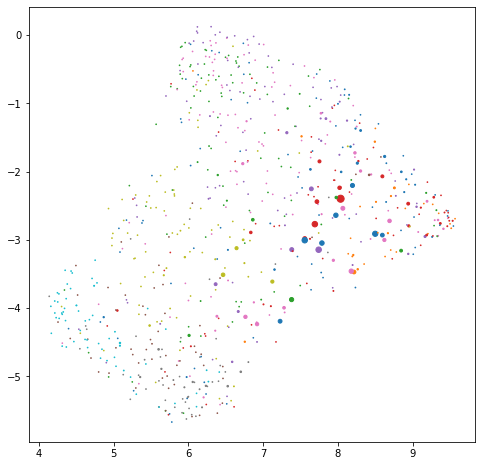

In [764]:
activ = dists.data.cpu()[i]
# activ = activ - activ.min()
# activ = torch.exp(activ)
# activ = np.maximum(activ*5, 0.0)

i += 1
print(f"{i}/{len(dists)}, sum: {activ.sum()}")
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*50, 0.5), cmap="tab10")
# activ = np.maximum(activ*5, 0.0)
# plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=activ, cmap="tab10")

In [611]:
aa = dists.data.cpu()[i]
aa.mean(), aa.min(), aa.max(), aa.std()

(tensor(0.0537), tensor(1.1403e-06), tensor(1.), tensor(0.1184))

In [612]:
j = 0

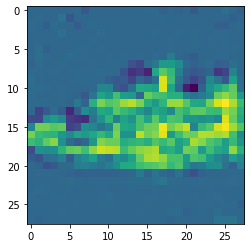

In [631]:
# plt.imshow(xx.cpu()[j].reshape(28,28))
plt.imshow(centers[j].reshape(28,28))
j += 1